<a href="https://colab.research.google.com/github/Krupa049/MLP/blob/main/MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
path = '/content/names.txt'

In [3]:
words = open(path, 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [6]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [55]:
block_size = 3
X, Y = [], []

for w in words:
  #print(w)
  context = [0] * block_size
  for ch in w + '.':
    ix = stoi[ch]
    X.append(context)
    Y.append(ix)
    #print(''.join(itos[i] for i in context), '--->', itos[ix])
    context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [56]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([228146, 3]), torch.int64, torch.Size([228146]), torch.int64)

In [94]:
def build_dataset(words):
  bloack_size = 3
  X, Y = [], []
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [95]:
len(words)

32033

In [96]:
n1

25626

In [97]:
n2

28829

In [11]:
C = torch.randn((27, 2))

In [20]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [21]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [32]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [33]:
h

tensor([[-0.0989, -0.9928,  0.9998,  ..., -0.7803, -0.8177,  0.8309],
        [-0.7156, -0.9991,  0.9951,  ..., -0.9921, -0.9797,  0.0794],
        [ 0.1830, -0.6197,  0.9982,  ..., -0.9430, -0.3476, -0.9986],
        ...,
        [-0.8074, -0.9937, -0.7466,  ...,  0.7971, -0.1439, -0.6137],
        [ 0.9469, -0.9702,  1.0000,  ..., -0.0732, -0.6319, -0.8094],
        [-0.9589, -0.9999, -0.9104,  ..., -0.2326, -0.6037, -0.8249]])

In [34]:
h.shape

torch.Size([32, 100])

In [35]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [37]:
logits = h @ W2 + b2

In [38]:
logits.shape

torch.Size([32, 27])

In [39]:
counts = logits.exp()

In [40]:
prob = counts / counts.sum(1, keepdims=True)

In [41]:
prob.shape

torch.Size([32, 27])

In [43]:
loss = -prob[torch.arange(32), Y].log().mean()
loss

tensor(14.7375)

In [98]:
Xtr.shape, Ytr.shape

(torch.Size([182580, 3]), torch.Size([182580]))

In [130]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [131]:
sum(p.nelement() for p in parameters)

11897

In [132]:
for p in parameters:
  p.requires_grad = True

In [133]:
 lre = torch.linspace(-3, 0, 1000)
 lrs = 10**lre

In [134]:
lri = []
lossi = []
stepi = []

In [140]:
for i in range(50000):

  ix = torch.randint(0, Xtr.shape[0], (32,))
  emb = C[X[ix]]
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
  logits = h @ W2 +b2
  #counts = logits.exp()
  #prob = counts / counts.sum(1, keepdims=True)
  #loss = -prob[torch.arange(32), Y].log().mean()
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())

  for p in parameters:
    p.grad = None
  loss.backward()

  #lr = lrs[i]
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  #lri.append(lre[i])
  stepi.append(i)
  lossi.append(loss.log10().item())

#print(loss.item())

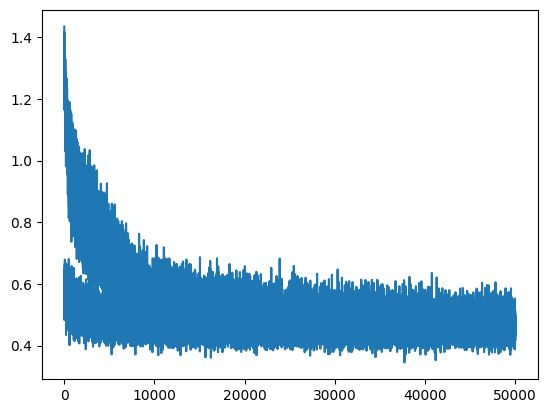

In [141]:
plt.plot(stepi, lossi)

In [142]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.9110, grad_fn=<NllLossBackward0>)

In [143]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1, 30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.9079, grad_fn=<NllLossBackward0>)

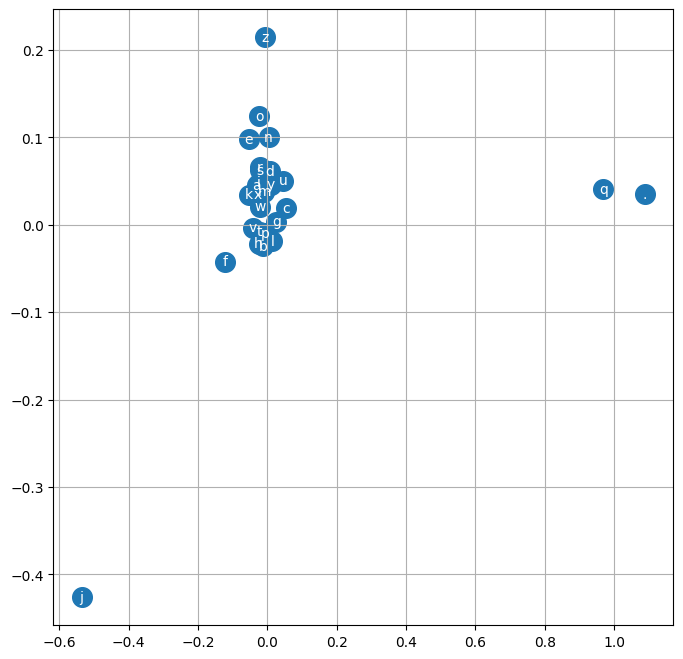

In [144]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
  plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')